# Probabilistic modeling for dual line fitting with JAX

Here we will learn on how to use JAX to perform gradient descent to fit two line from datapoints that were generated by two separate processes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

In [2]:
def generate_data(n_points=[50,50], par1 = [1,1], par2 = [1,1], noise= 50):
    x1=(np.arange(n_points[0])*par1[0]).astype(int)
    y1=(np.arange(n_points[0])*par1[1]).astype(int)
    x2=(np.arange(n_points[1])*par2[1]).astype(int)
    y2=(np.arange(n_points[1])*par2[0]).astype(int)

    x1=x1+np.random.randint(0,noise,len(x1))
    y1=y1+np.random.randint(0,noise,len(x1))
    
    x2=x2+np.random.randint(0,noise,len(x2))
    y2=y2+np.random.randint(0,noise,len(x2))

    xy=np.hstack([np.vstack([x1,y1]),np.vstack([x2,y2])]).T

    group=np.concatenate([np.ones(n_points[0]),np.zeros(n_points[0])])
    
    return x1,x2,y1,y2, xy, group

In [3]:
np.random.seed(42)
x1,x2,y1,y2, xy,group =generate_data(n_points=[50,50], par1 = [20,1], par2 = [10,10], noise= 100)

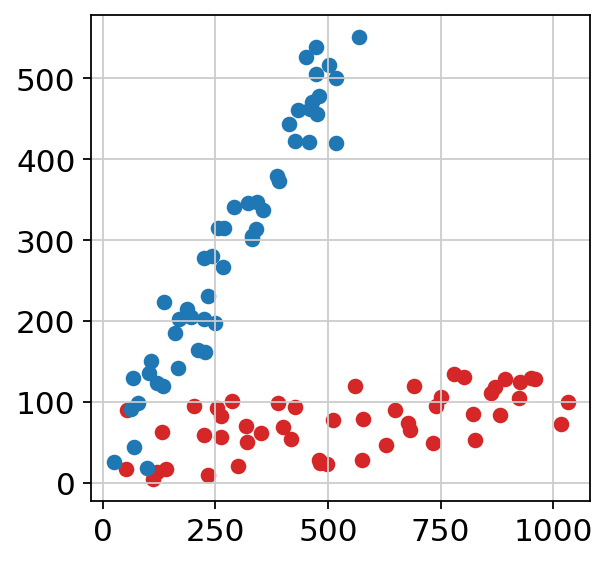

In [4]:
sc.set_figure_params()
plt.scatter(x1,y1,c="tab:red")
plt.scatter(x2,y2,c="tab:blue")

## Introducing our model

To fit these two sets of points, we will employ a mixture of probabilitic models:

$$
\sum_i \log P(\hat{s_i})= \sum_i \log [P(\hat{s_i}|l_1)+P(\hat{s_i}|l_2)] \\
$$

We want to minimize $-\sum_i \log P(\hat{s_i})$. We will use a gaussian distribution to model assignment of point to each learned line:

$$
P(\hat{s_i}|l_1) = \exp^{\frac{-(l_1-s_i)^2}{\sigma}}
$$

The parameter $\sigma$ controls the spread of the gaussian distribution. While we could think of ways to include it as a learnable parameter, we will we fix it to `0.1` for this time, which is lower than the spread of our data.

In [5]:
import jax
import jax.numpy as jnp

# Using jax.jit compiles to function for quicker runs
@jax.jit
def loss_fun(slopes,sigma):
    # Estimate lines using slope parameters
    l1 = jnp.dot(xy[:,0], slopes[0])
    l2 = jnp.dot(xy[:,0], slopes[1])

    # Calculate squared error
    r1 = (l1 - xy[:,1])**2
    r2 = (l2 - xy[:,1])**2

    # Apply a Gaussian-like transformation to the errors
    # Values are capped to prevent numerically unstable large exponents.
    e1 = jnp.exp(-jnp.where(r1>60,60,r1)/sigma)
    e2 = jnp.exp(-jnp.where(r2>60,60,r2)/sigma)

    # Combine loss from both lines
    return -jnp.log(e1+e2).sum()

## Initialisation of Slope Parameters

A proper strategy to get good initial parameters is to obtain the slope of a single linear fit using least-squares method, and assign that slope to both lines to be fitted:

In [6]:
# Normalizing between 0 and 1 for better consistency between parameters
xy=xy/xy.max(axis=0)

s, _, _, _ = np.linalg.lstsq(xy[:,0].reshape(-1,1), xy[:,1].reshape(-1,1),rcond=None)
slopes = [s.ravel()[0],s.ravel()[0]+0.001] # we add a little offset to help the start of training

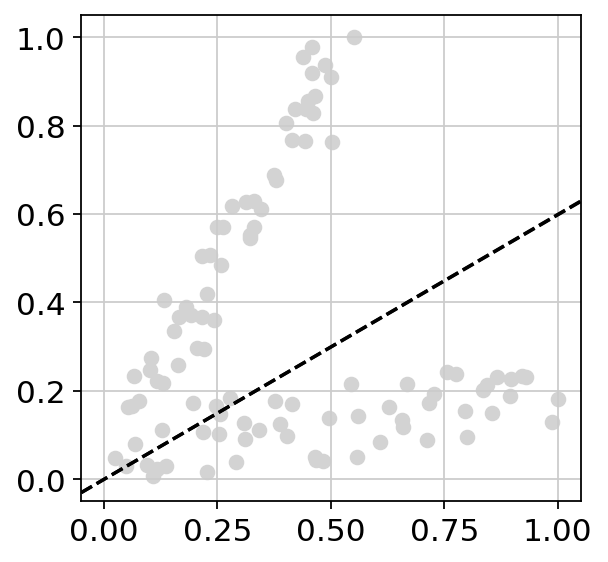

In [7]:
plt.scatter(xy[:,0],xy[:,1],c="lightgrey")
sl1 = slopes[0]
sl2 = slopes[1]
line1 = plt.axline([0, 0], slope=sl1, c="k", linestyle="--", zorder=99999)
line2 = plt.axline([0, 0], slope=sl2, c="k", linestyle="--", zorder=99999)

We have here to lines, nearly overlapping.

## JAX-Based Optimization Loop for Parameter Tuning 

In [8]:
import optax
optimizer=optax.adam(1e-2)

In [9]:
# initialize Adam with our slope parameters to track
opt_state = optimizer.init(slopes)
all_slopes=[]
all_slopes.append(slopes)
objs=[]
for step in range(200):
    # calculate current loss and related gradients
    obj, grads = jax.value_and_grad(loss_fun)(slopes,sigma=0.1)
    # takes in the current optimizer state and gradients and 
    # returns the updates that need to be applied to the parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    # applies the updates from the gradient transforms to the current parameters to return new ones
    slopes = optax.apply_updates(slopes, updates)
    # saving slope params and loss output for current iteration
    all_slopes.append(slopes)
    objs.append(obj)
    if ((step+1) % 20 == 0):
        print(f'Step {step+1}, Objective: {obj.item()}')

Step 20, Objective: 30.658523559570312
Step 40, Objective: 13.811946868896484
Step 60, Objective: 1.242879867553711
Step 80, Objective: -6.383170127868652
Step 100, Objective: -10.343793869018555
Step 120, Objective: -12.140351295471191
Step 140, Objective: -12.850984573364258
Step 160, Objective: -13.094189643859863
Step 180, Objective: -13.165483474731445
Step 200, Objective: -13.183143615722656


### Loss function

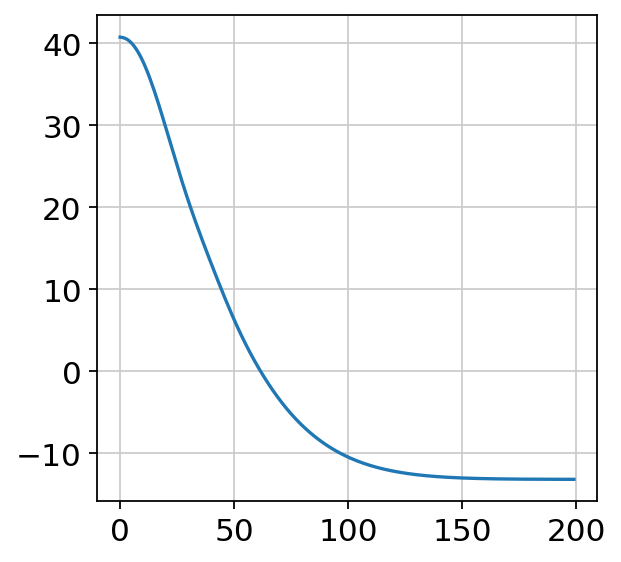

In [10]:
plt.plot(objs)

It seems we have converged after 150 iterations, let's look at the learned linear fits:

In [11]:
slopes

[Array(0.25446418, dtype=float32), Array(1.8191806, dtype=float32)]

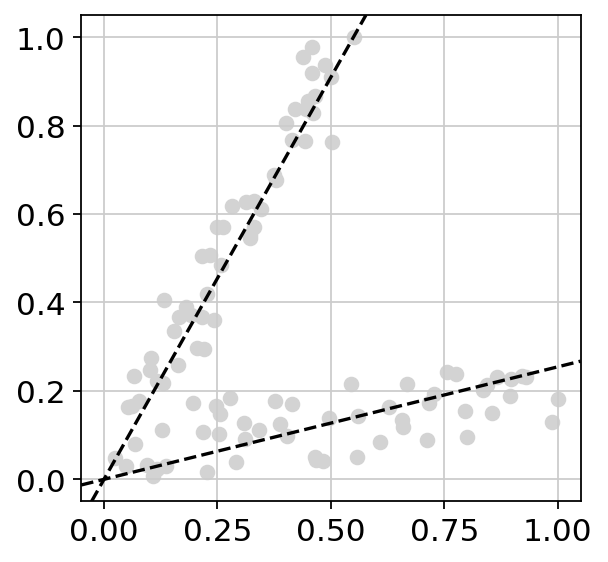

In [12]:
sc.set_figure_params()
plt.scatter(xy[:,0],xy[:,1],c="lightgrey")
plt.axline([0,0],slope=slopes[0],c="k",linestyle="--",zorder=99999)
plt.axline([0,0],slope=slopes[1],c="k",linestyle="--",zorder=99999)

The model works well, we captured both processes!

### Visualising the learning of parameters

It is quite fun to look the actual updates of the slope parameters as the gradient descent occurs, here is an animation showing also as a color the probability assignment of each point to one line or the other.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import matplotlib
from matplotlib.colors import Normalize

def get_assignment(xy, slopes, sigma):
    l1 = np.dot(xy[:, 0], slopes[0])
    l2 = np.dot(xy[:, 0], slopes[1])
    r1 = (l1 - xy[:, 1])**2
    r2 = (l2 - xy[:, 1])**2
    sresid = np.exp(-(r1 - r2) / sigma)
    return sresid / (1 + sresid)

def generate_gif(xy, all_slopes, sigma):
    # Set up the initial plot
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)

    # Initialize colormap and normalization
    cmap = matplotlib.colormaps["bwr"]
    norm = Normalize(vmin=0, vmax=1)

    # Initial scatter plot
    sc = ax.scatter(xy[:, 0], xy[:, 1],
                    facecolors=cmap(norm(get_assignment(xy, all_slopes[0],sigma))), 
                    edgecolors='k',linewidth=.5,s=50)

    # Initial axlines
    sl1 = all_slopes[0][0]
    sl2 = all_slopes[0][1]
    line1, = ax.plot([], [], 'k--', zorder=99999)
    line2, = ax.plot([], [], 'k--', zorder=99999)

    # Update function
    def update(frame):
        # Remove previous lines
        line1.set_data([], [])
        line2.set_data([], [])

        # Update scatter plot colors
        sc.set_facecolors(cmap(norm(get_assignment(xy, all_slopes[frame],sigma))))

        # Add new lines with updated slopes
        sl1 = all_slopes[frame][0]
        sl2 = all_slopes[frame][1]
        x1 = np.array([-10, 10])
        y1 = sl1 * x1
        x2 = np.array([-10, 10])
        y2 = sl2 * x2
        line1.set_data(x1, y1)
        line2.set_data(x2, y2)
        return sc, line1, line2

    # Create the animation
    frames = np.concatenate([np.zeros(30,dtype=int),np.arange(len(all_slopes))])
    ani = animation.FuncAnimation(fig, update,frames=frames,blit=True, repeat=True)

    # To save the animation using Pillow as a gif
    writer = animation.PillowWriter(fps=30,
                                     metadata=dict(artist='Me'),
                                     bitrate=1800)
    ani.save('optim.gif', writer=writer)

    # plt.show()
    plt.close()


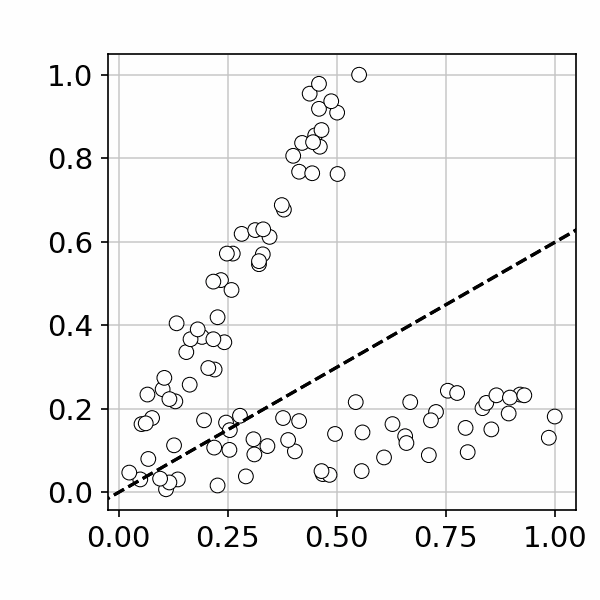

In [14]:
from IPython.display import Image
Image(open('optim.gif','rb').read())

## Trying a higher learning rate

Let's increase the learning rate by one order of magnitude:

In [15]:
optimizer=optax.adam(1e-1)
s, _, _, _ = np.linalg.lstsq(xy[:,0].reshape(-1,1), xy[:,1].reshape(-1,1),rcond=None)
slopes = [s.ravel()[0],s.ravel()[0]+0.001]

opt_state = optimizer.init(slopes)
all_slopes=[]
all_slopes.append(slopes)
objs=[]
for step in range(200):
    obj, grads = jax.value_and_grad(loss_fun)(slopes,sigma=0.1)
    updates, opt_state = optimizer.update(grads, opt_state)
    slopes = optax.apply_updates(slopes, updates)
    all_slopes.append(slopes)
    objs.append(obj)
    if ((step+1) % 20 == 0):
        print(f'Step {step+1}, Objective: {obj.item()}')

Step 20, Objective: -9.618911743164062
Step 40, Objective: -12.614023208618164
Step 60, Objective: -13.086435317993164
Step 80, Objective: -13.182458877563477
Step 100, Objective: -13.186990737915039
Step 120, Objective: -13.187236785888672
Step 140, Objective: -13.18742847442627
Step 160, Objective: -13.187431335449219
Step 180, Objective: -13.187433242797852
Step 200, Objective: -13.187432289123535


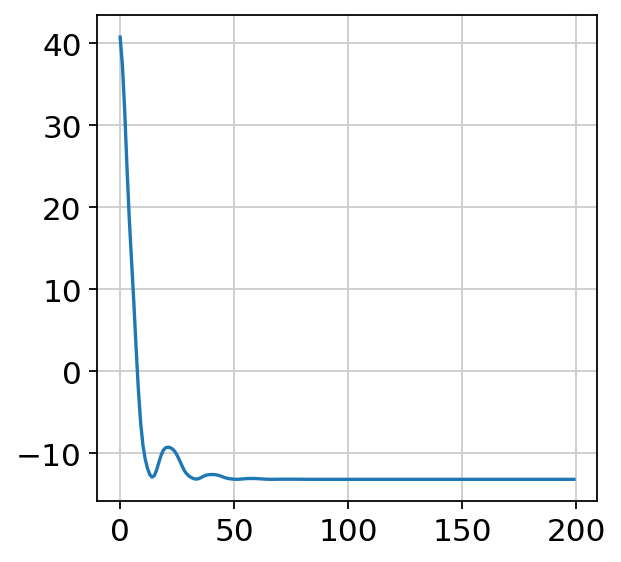

In [16]:
plt.plot(objs)

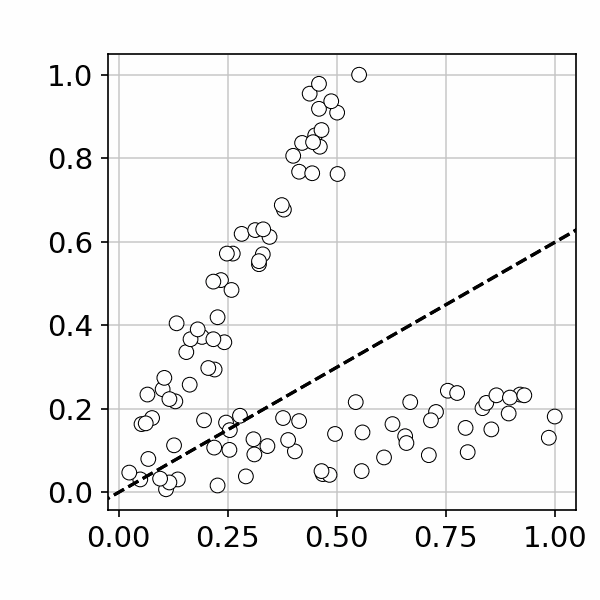

In [17]:
generate_gif(xy, all_slopes, sigma=0.1)
Image(open('optim.gif','rb').read())

Here is a good example of the (spring-like!) flexibility of Adam optimizer: The large learning rate lead to an overshoot of the slope estimation, which is progressively dampened as the train progress, we even reach the global minima more rapidely!

## Estimating the performance of our model

Let's have a look at how good our model is in recovering the two initial groups of points:

In [18]:
f=get_assignment(xy,slopes,sigma=.1)

In [19]:
from sklearn.metrics import roc_auc_score
print(f"AUC score: {roc_auc_score(group,f):.4f}")

AUC score: 0.9976


We are doing a very good job at recovering the two underlying processes!